#环境配置系列

##配置谷歌环境

In [1]:
#认证
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpl0owdwa4/pubring.gpg' created
gpg: /tmp/tmpl0owdwa4/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [0]:
#挂载云盘
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

##编程环境

In [3]:
!pip install xgboost
import xgboost as xgb
import pandas as pd
import numpy as np

##读取数据及初始处理

In [4]:
#读取数据
train_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_train_20180301.txt"," ")
test_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_test_a_20180301.txt"," ")
print(len(train_csv),len(test_csv))

478138 18371


In [5]:
train_pd = train_csv.drop_duplicates("instance_id").copy()
test_pd = test_csv.drop_duplicates("instance_id").copy()
print(len(train_csv),len(test_csv))
#补充时间数据
import time
train_pd['day']=train_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_pd['hour']=train_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
test_pd['day']=test_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
test_pd['hour']=test_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
#展示列名
print("columns length:",len(train_pd.columns))
print("列名：",train_pd.columns)
#时间列
train_time_list = sorted(train_pd["day"].unique())
print("时间序列：",train_time_list)

478138 18371
columns length: 29
列名： Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'day', 'hour'],
      dtype='object')
时间序列： ['2018-09-18', '2018-09-19', '2018-09-20', '2018-09-21', '2018-09-22', '2018-09-23', '2018-09-24']


#特征尝试和验证

In [0]:
train_pd = train_csv.drop_duplicates("instance_id").copy()
test_pd = test_csv.drop_duplicates("instance_id").copy()

#补充时间数据
import time
train_pd['day']=train_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_pd['hour']=train_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
test_pd['day']=test_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
test_pd['hour']=test_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))

feature_list = []
all_data = pd.concat([train_pd,test_pd])
all_data["category"] =  list(map(lambda x:x.split(";")[1],all_data["item_category_list"]))
# feature_one_hot = pd.get_dummies(
#     all_data[["category","item_price_level","user_age_level"]],
#     columns=["category","item_price_level","user_age_level"],
#     prefix=["category","price_level","age_level"]
# )
# #测试后发现item_pv_level贡献很小，且带来太多维度，舍弃
# feature_list += list(feature_one_hot.columns)
# all_data = pd.concat([all_data,feature_one_hot],axis=1)


#重新替换train_pd，test_pd
train_pd = all_data[:len(train_pd)]
test_pd = all_data[len(train_pd):]

#分割线下测试和训练集
train_m = train_pd[(train_pd["day"]>='2018-09-18')&(train_pd["day"]<='2018-09-22')]
test_m = train_pd[(train_pd["day"]>='2018-09-23')]





###双特征

In [0]:
######################双特征算出的trade_ratio###########################

def set_gender_brand_ratio(train_df,test_df):
  ret = train_df[["user_gender_id","item_brand_id","is_trade"]].copy()
  pv_level_ratio_pd = (ret.groupby(["user_gender_id","item_brand_id"]).sum()["is_trade"])/\
    (ret.groupby(["user_gender_id","item_brand_id"]).count()["is_trade"])
  trade_ratio_pd = pv_level_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"gender_brand_ratio"})
  na_value = 0
  train_df = pd.merge(train_df,trade_ratio_pd,on=["user_gender_id","item_brand_id"],how="left").fillna(na_value)
  test_df = pd.merge(test_df,trade_ratio_pd,on=["user_gender_id","item_brand_id"],how="left").fillna(na_value)
  return train_df,test_df
train_m,test_m = set_gender_brand_ratio(train_m,test_m)
if "gender_brand_ratio" not in feature_list:
  feature_list.append("gender_brand_ratio")

###单特征

In [0]:
##################单特征或单特征的trade_ratio###########################

# def set_item_trade_ratio(train_df,test_df):
#   ret = train_df[["item_id","is_trade"]].copy()
#   item_trade_ratio_pd = (ret.groupby("item_id").sum()["is_trade"])/\
#     (ret.groupby("item_id").count()["is_trade"])
#   trade_ratio_pd = item_trade_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_trade_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_id",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_id",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_trade_ratio(train_m,test_m)
# if "item_trade_ratio" not in feature_list:
#   feature_list.append("item_trade_ratio")

# def set_brand_trade_ratio(train_df,test_df):
#   ret = train_df[["item_brand_id","is_trade"]].copy()
#   brand_trade_ratio_pd = (ret.groupby("item_brand_id").sum()["is_trade"])/\
#     (ret.groupby("item_brand_id").count()["is_trade"])
#   trade_ratio_pd = brand_trade_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"brand_trade_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_brand_id",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_brand_id",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_brand_trade_ratio(train_m,test_m)
# if "brand_trade_ratio" not in feature_list:
#   feature_list.append("brand_trade_ratio")

# def set_item_city_ratio(train_df,test_df):
#   ret = train_df[["item_city_id","is_trade"]].copy()
#   item_city_ratio_pd = (ret.groupby("item_city_id").sum()["is_trade"])/\
#     (ret.groupby("item_city_id").count()["is_trade"])
#   trade_ratio_pd = item_city_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_city_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_city_id",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_city_id",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_city_ratio(train_m,test_m)
# if "item_city_ratio" not in feature_list:
#   feature_list.append("item_city_ratio")

# def scale_to_one(train_df,test_df,column):
#   all_df = pd.concat([train_df,test_df])
#   all_df[column] = (all_df[column]-all_df[column].min()) / (all_df[column].max()-all_df[column].min())
#   train_df = all_df[:len(train_df)]
#   test_df = all_df[len(test_df):]
#   return train_df,test_df
  
# if "shop_review_positive_rate" not in feature_list:
#   feature_list.append("shop_review_positive_rate")

# if "shop_score_service" not in feature_list:
#   feature_list.append("shop_score_service")

# if "shop_score_delivery" not in feature_list:
#   feature_list.append("shop_score_delivery")

# if "shop_score_description" not in feature_list:
#   feature_list.append("shop_score_description")

###贡献过小，AUC低于55的特征

In [0]:
#################综合后贡献不大，去掉提升的特征#####################

# def set_item_price_ratio(train_df,test_df):
#   ret = train_df[["item_price_level","is_trade"]].copy()
#   item_price_ratio_pd = (ret.groupby("item_price_level").sum()["is_trade"])/\
#     (ret.groupby("item_price_level").count()["is_trade"])
#   trade_ratio_pd = item_price_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_price_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_price_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_price_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_price_ratio(train_m,test_m)
# if "item_price_ratio" not in feature_list:
#   feature_list.append("item_price_ratio")

# def set_item_sales_ratio(train_df,test_df):
#   ret = train_df[["item_sales_level","is_trade"]].copy()
#   item_sales_ratio_pd = (ret.groupby("item_sales_level").sum()["is_trade"])/\
#     (ret.groupby("item_sales_level").count()["is_trade"])
#   trade_ratio_pd = item_sales_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_sales_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_sales_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_sales_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_sales_ratio(train_m,test_m)
# if "item_sales_ratio" not in feature_list:
#   feature_list.append("item_sales_ratio")

#####################AUC低于55的特征#########################


# def set_item_collected_ratio(train_df,test_df):
#   ret = train_df[["item_collected_level","is_trade"]].copy()
#   item_collected_ratio_pd = (ret.groupby("item_collected_level").sum()["is_trade"])/\
#     (ret.groupby("item_collected_level").count()["is_trade"])
#   trade_ratio_pd = item_collected_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_collected_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_collected_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_collected_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_item_collected_ratio(train_m,test_m)
# if "item_collected_ratio" not in feature_list:
#   feature_list.append("item_collected_ratio")


# def set_shop_star_ratio(train_df,test_df):
#   ret = train_df[["shop_star_level","is_trade"]].copy()
#   shop_star_ratio_pd = (ret.groupby("shop_star_level").sum()["is_trade"])/\
#     (ret.groupby("shop_star_level").count()["is_trade"])
#   trade_ratio_pd = shop_star_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"shop_star_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="shop_star_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="shop_star_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_shop_star_ratio(train_m,test_m)
# if "shop_star_ratio" not in feature_list:
#   feature_list.append("shop_star_ratio")

# def set_pv_level_ratio(train_df,test_df):
#   ret = train_df[["item_pv_level","is_trade"]].copy()
#   pv_level_ratio_pd = (ret.groupby("item_pv_level").sum()["is_trade"])/\
#     (ret.groupby("item_pv_level").count()["is_trade"])
#   trade_ratio_pd = pv_level_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"pv_level_ratio"})
#   na_value = 0
#   train_df = pd.merge(train_df,trade_ratio_pd,on="item_pv_level",how="left").fillna(na_value)
#   test_df = pd.merge(test_df,trade_ratio_pd,on="item_pv_level",how="left").fillna(na_value)
#   return train_df,test_df
# train_m,test_m = set_pv_level_ratio(train_m,test_m)
# if "pv_level_ratio" not in feature_list:
#   feature_list.append("pv_level_ratio")

##验证

[0]	train-auc:0.674747	train-logloss:0.490703	test-auc:0.590346	test-logloss:0.489727
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[1]	train-auc:0.700724	train-logloss:0.367958	test-auc:0.607025	test-logloss:0.366223
[2]	train-auc:0.70117	train-logloss:0.286641	test-auc:0.607381	test-logloss:0.28431
[3]	train-auc:0.704661	train-logloss:0.230402	test-auc:0.609818	test-logloss:0.227572
[4]	train-auc:0.710204	train-logloss:0.190523	test-auc:0.612571	test-logloss:0.187265
[5]	train-auc:0.718885	train-logloss:0.161876	test-auc:0.615494	test-logloss:0.158258
[6]	train-auc:0.71921	train-logloss:0.141157	test-auc:0.615401	test-logloss:0.137263
[7]	train-auc:0.722981	train-logloss:0.126141	test-auc:0.613794	test-logloss:0.122077
[8]	train-auc:0.723358	train-logloss:0.115254	test-auc:0.614036	test-logloss:0.11107
[9]	train-auc:0.723632	train-logloss:0.107378	test-auc:0.614551	test-logloss:0.10

[45]	train-auc:0.724723	train-logloss:0.088115	test-auc:0.613356	test-logloss:0.091201
[46]	train-auc:0.724723	train-logloss:0.088115	test-auc:0.613356	test-logloss:0.091203
[47]	train-auc:0.724723	train-logloss:0.088115	test-auc:0.613356	test-logloss:0.091203
[48]	train-auc:0.724723	train-logloss:0.088115	test-auc:0.61336	test-logloss:0.091193
[49]	train-auc:0.724723	train-logloss:0.088115	test-auc:0.61336	test-logloss:0.091192
[50]	train-auc:0.724724	train-logloss:0.088114	test-auc:0.613319	test-logloss:0.09128
[51]	train-auc:0.724724	train-logloss:0.088114	test-auc:0.613319	test-logloss:0.091279
[52]	train-auc:0.724724	train-logloss:0.088114	test-auc:0.613319	test-logloss:0.09128
[53]	train-auc:0.724723	train-logloss:0.088112	test-auc:0.613322	test-logloss:0.09137
[54]	train-auc:0.724723	train-logloss:0.088112	test-auc:0.613322	test-logloss:0.091367
[55]	train-auc:0.724723	train-logloss:0.088112	test-auc:0.613322	test-logloss:0.09137
[56]	train-auc:0.724723	train-logloss:0.088112	te

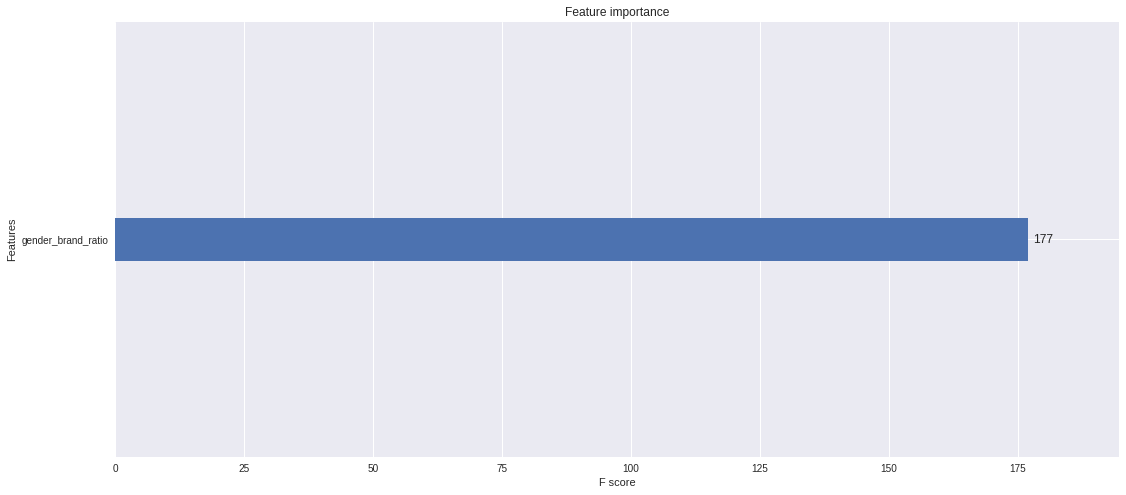

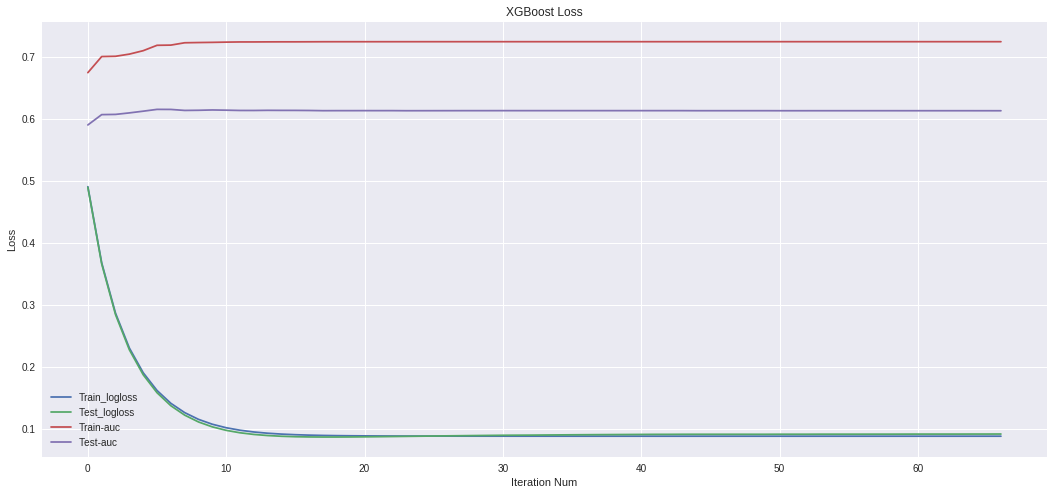

In [76]:
#alpha 30, lambda 15, gamma 2
param = {}
param["eta"] = 0.25
param["min_child_weight"] = 1
param["max_depth"] = 3
param["lambda"] = 15 #控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。 默认1
param["alpha"] = 4 #控制模型复杂程度的权重值的 L1 正则项参数，参数值越大，模型越不容易过拟合。 默认0
param["gamma"] = 1 # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
param["subsample"]=0.8
param["colsample_bytree"]=0.8
param["objective"] = "binary:logistic"
param["eval_metric"]=[ "auc","logloss"]#error,logloss,auc
param["silent"] = 1
num_round = 500
eval_result={}

X = train_m[feature_list].copy()
Y = train_m["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
X_t = test_m[feature_list].copy()
Y_t = test_m["is_trade"].copy()
test_set = xgb.DMatrix(X_t,label=Y_t)
watchlist = [(train_set,'train'), (test_set, 'test')]
model = xgb.train( param, train_set, num_round, watchlist,verbose_eval=True,evals_result=eval_result,early_stopping_rounds=int(0.1*num_round))
limit = model.best_ntree_limit

from matplotlib import pyplot 
from xgboost import plot_importance
#plot feature importance
ax = plot_importance(model,max_num_features=50)
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.show()

#plot logloss
epochs = len(eval_result['train']['logloss'])  
x_axis = range(0, epochs)  
fig, ax = pyplot.subplots()  
ax.plot(x_axis, eval_result['train']['logloss'], label='Train_logloss')  
ax.plot(x_axis, eval_result['test']['logloss'], label='Test_logloss')  
ax.plot(x_axis, eval_result['train']['auc'], label='Train-auc')  
ax.plot(x_axis, eval_result['test']['auc'], label='Test-auc') 
ax.legend()
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.ylabel('Loss')  
pyplot.xlabel('Iteration Num')  
pyplot.title('XGBoost Loss')  
pyplot.show()


#训练

##xgboost

###参数控制

In [0]:
#alpha 30, lambda 15, gamma 2
param = {}
param["eta"] = 0.25
param["min_child_weight"] = 1
param["max_depth"] = 3
param["lambda"] = 15 #控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。 默认1
param["alpha"] = 4 #控制模型复杂程度的权重值的 L1 正则项参数，参数值越大，模型越不容易过拟合。 默认0
param["gamma"] = 1 # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
param["subsample"]=0.8
param["colsample_bytree"]=0.8
param["objective"] = "binary:logistic"
param["eval_metric"]=[ "auc","logloss"]#error,logloss,auc
param["silent"] = 1
num_round = 500
eval_result={}

###训练模型

In [0]:
X = train_m[feature_list].copy()
Y = train_m["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
X_t = test_m[feature_list].copy()
Y_t = test_m["is_trade"].copy()
test_set = xgb.DMatrix(X_t,label=Y_t)
watchlist = [(train_set,'train'), (test_set, 'test')]
model = xgb.train( param, train_set, num_round, watchlist,verbose_eval=True,evals_result=eval_result,early_stopping_rounds=int(0.1*num_round))
limit = model.best_ntree_limit

###结果展示

In [0]:
from matplotlib import pyplot 
from xgboost import plot_importance
#plot feature importance
ax = plot_importance(model,max_num_features=50)
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.show()

#plot logloss
epochs = len(eval_result['train']['logloss'])  
x_axis = range(0, epochs)  
fig, ax = pyplot.subplots()  
ax.plot(x_axis, eval_result['train']['logloss'], label='Train_logloss')  
ax.plot(x_axis, eval_result['test']['logloss'], label='Test_logloss')  
ax.plot(x_axis, eval_result['train']['auc'], label='Train-auc')  
ax.plot(x_axis, eval_result['test']['auc'], label='Test-auc') 
ax.legend()
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.ylabel('Loss')  
pyplot.xlabel('Iteration Num')  
pyplot.title('XGBoost Loss')  
pyplot.show()


###正式训练重新生成特征

###结果预测

In [0]:
#总训练集生成
X = train_pd[feature_list].copy()
Y = train_pd["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
#测试集生成
X_t = test_pd[feature_list].copy() 
test_set = xgb.DMatrix(X_t)
#训练总模型
watchlist = [(train_set,'train')]
final_model = xgb.train( param, train_set, limit,watchlist)
#预测
predict_out = final_model.predict(test_set,ntree_limit=limit)
test_pd["predicted_score"] = predict_out
result = test_pd[["instance_id","predicted_score"]].copy()

###结果保存

In [0]:
#保存文件
time_string = time.strftime('%Y_%m_%d_%H_%M_%S',time.localtime(time.time()+8*3600))
file_name = "drive/Colab_Notebooks/output/"+time_string+ '_'+str(model.best_score).split(".")[1]+".csv"
result.to_csv(file_name,index=False,sep=" ",float_format='%.6f')
print(file_name)

drive/Colab_Notebooks/output/2018_03_03_22_08_48_030655.csv
